In [1]:
import tkinter as tk
from solcore.solar_cell_solver import solar_cell_solver
import time
# from lib_save_file import *
from lib_save_data import *
# from material_of_InSb_GaSb import *
from material_and_layer_QD import *
from solcore.light_source import LightSource
import matplotlib.pyplot as plt
import solcore.poisson_drift_diffusion as PDD
from solcore.structure import SolcoreMaterialToStr, ToStructure, ToLayer, InLineComposition
import mpld3
# import numpy as np
from matplotlib import pyplot as plt, cm, ticker
from solcore.poisson_drift_diffusion.DriftDiffusionUtilities import SetMeshParameters
from solcore.structure import SolcoreMaterialToStr
# from numpy import trapz
# from solcore.light_source import LightSource
from material_of_InSb_GaSb import *
from material_and_layer_QD import *
from lib_save_file import *
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource
import time


C:\Users\usuwa\anaconda3\Lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


In [2]:
wl = np.linspace(350, 3000, 401) * 1e-9  # version1
light_source = LightSource(source_type="standard"
                           , version="AM1.5g"
                           , x=wl
                           , output_units="photon_flux_per_m"
                           , concentration=1
                           )
vint = np.linspace(-3, 3, 600)
V = np.linspace(-1.5, 0, 300)  # np
# V = np.linspace(-3.5, 3.5, 300)
# V = np.linspace(0,3.5,300) # pn
con_light = np.logspace(0, 3, 5)
# con_light = np.linspace(1, 2, 5)

data = {"allI": [],
        "Isc": [],
        "Voc": [],
        "FF": [],
        "Pmpp": [],
        "absorbed": [],
        "xsc": [],
        "nsc": [],
        "psc": [],
        "xeq": [],
        "neq": [],
        "peq": [],
        }
deta_mode = {
    "allI": [],
    "Isc": [],
    "Voc": [],
    "FF": [],
    "Pmpp": [],
    "absorbed": [],
    "mode": [],
    "xsc": [],
    "nsc": [],
    "psc": [],
    "xeq": [],
    "neq": [],
    "peq": [],
}
set_of_data = []

In [42]:
from solcore.state import State
import mpld3
# import numpy as np
from matplotlib import pyplot as plt, cm, ticker
from solcore.poisson_drift_diffusion.DriftDiffusionUtilities import SetMeshParameters
from solcore.structure import SolcoreMaterialToStr
# from numpy import trapz
# from solcore.light_source import LightSource
from material_of_InSb_GaSb import *
from material_and_layer_QD import *
from lib_save_file import *
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource
import time

vint = np.linspace(-3, 3, 600)
V = np.linspace(-1.5, 0, 300)  # np

wl = np.linspace(350, 3000, 401) * 1e-9  # version1
light_source = LightSource(source_type="standard"
                           , version="AM1.5g"
                           , x=wl
                           , output_units="photon_flux_per_m"
                           , concentration=1
                           )
data_solar_cell = dict(
    T=None,
    absorbed=None,
    short_circuit_data=None,
    pdd_data=None,
    recombination_currents=None,
    equilibrium_data=None,
    iv=None,
    qe=None,
    offset=0,
    note='note',
    list_structure=[],
    x_axis=[],
    x_axis_name='None',
    mode='None',

)


def defultsaveing(solarcell, saveaddrest, version, save=True):
    saveaddrest["T"] = solarcell.T
    saveaddrest['absorbed'] = solarcell.absorbed
    saveaddrest['short_circuit_data'] = solarcell[0].short_circuit_data.copy()
    saveaddrest['pdd_data'] = solarcell[0].pdd_data.copy()
    saveaddrest['recombination_currents'] = solarcell[0].recombination_currents.copy()
    saveaddrest['equilibrium_data'] = solarcell[0].equilibrium_data.copy()
    saveaddrest['iv'] = solarcell.iv.copy()
    saveaddrest['offset'] = solarcell[0].offset
    saveaddrest['qe'] = solarcell[0].qe.copy()
    if save:
        with open(f'{version}.pkl', 'wb') as fin:
            pickle.dump(saveaddrest, fin)
            print('dictionary saved successfully to file')
    return saveaddrest


def load_old_data(version):
    with open(f'{version}', 'rb') as fp:
        data = pickle.load(fp)
    print('Loading dictionary complete')
    # print(data["allI"])
    return data


def save_set_of_data_sun_constant(set_of_data, version, focus_area=None):
    if focus_area is None:
        focus_area = (350, 650)
    simpifly = None
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
    fig_5, ax1_5 = plt.subplots(1, 1, figsize=(6, 4))
    fig1, axes = plt.subplots(2, 2, figsize=(11.25, 8))
    fig2, axIV = plt.subplots(1, 1, figsize=(8, 6))
    fig3, axCar = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig3_5, axCar2 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig_b1, band1 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig_b2, band2 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    if len(set_of_data) > 5:
        simpifly = np.linspace(0, len(set_of_data), 5)
        simpifly = [int(i) for i in simpifly].append(len(set_of_data) - 1)
    Pmpp = [];
    Isc = [];
    Voc = [];
    FF = []
    for num, data in enumerate(set_of_data):
        print(f'loading {data["mode"]}')
        ax1.plot(data['qe']["WL"] * 1e9, data["qe"]["EQE"], label=f"{data['mode']} ")
        ax1.legend(loc="upper right", frameon=False)
        ax1.set_xlabel("Wavelength (nm)")
        ax1.set_ylabel("EQE")
        ax1.set_ylim(0, 1.1)
        ax1.set_xlim(350, 1000)
        ax1.legend()
        plt.tight_layout()
        fig1.suptitle(f"{version}")

        ax1_5.plot(data['qe']["WL"] * 1e9, data["qe"]["EQE"], label=f"{data['mode']} ")
        ax1_5.legend(loc="upper right", frameon=False)
        ax1_5.set_xlabel("Wavelength (nm)")
        ax1_5.set_ylabel("EQE")
        ax1_5.set_ylim(0, 0.1)
        ax1_5.set_xlim(900, 3000)
        ax1_5.legend()
        fig_5.suptitle(f"{version}")

        # linestyle = ["-", "--", ":", "-."]
        # marker = [".", ",", "o", 'v', "^", "<", ">", "s", "p", "*", "h", "+", "x", "D", "d"]
        # color = ['blue','green','red','cyan','magenta','yellow','black','orange','purple']
        Pmpp.append(data["iv"]["Pmpp"])
        Isc.append(data["iv"]["Isc"])
        Voc.append(data["iv"]["Voc"])
        FF.append(data["iv"]["FF"])
        if simpifly is not None and num in simpifly:
            axIV.plot(-data["iv"]["IV"][0], data["iv"]["IV"][1] / -10, label=f"{data['mode']}")
        elif simpifly is None:
            axIV.plot(-data["iv"]["IV"][0], data["iv"]["IV"][1] / -10, label=f"{data['mode']}")

        axIV.set_ylim(0, 30)
        axIV.set_xlim(0, 1.5)
        axIV.set_xlabel("Voltage (V)")
        axIV.set_ylabel("J$_{SC}$ (mA/cm$^{2}$)")
        axIV.legend()
        plt.tight_layout()
        try:
            xsc = data["short_circuit_data"]['Bandstructure']['x'] + data['offset']
            nsc = data["short_circuit_data"]['Bandstructure']['n']
            psc = data["short_circuit_data"]['Bandstructure']['p']
            xeq = data["equilibrium_data"]['Bandstructure']['x'] + data['offset']
            neq = data["equilibrium_data"]['Bandstructure']['n']
            peq = data["equilibrium_data"]['Bandstructure']['p']
            axCar[num].set_title(data["mode"])
            axCar[num].semilogy(xsc * 1e9, nsc, 'b', label='e @ short circuit')
            axCar[num].semilogy(xsc * 1e9, psc, 'r', label='h @ short circuit')
            axCar[num].semilogy(xeq * 1e9, neq, 'b--', label='e @ equilibrium')
            axCar[num].semilogy(xeq * 1e9, peq, 'r--', label='h @ equilibrium')

            axCar[num].set_xlabel('Position (nm)')
            axCar[num].set_ylabel('Carrier density (m$^{-3}$)')
            axCar[num].legend()

            axCar2[num].set_title(data["mode"])
            axCar2[num].semilogy(xsc * 1e9, nsc, 'b', label='e @ short circuit')
            axCar2[num].semilogy(xsc * 1e9, psc, 'r', label='h @ short circuit')
            axCar2[num].semilogy(xeq * 1e9, neq, 'b--', label='e @ equilibrium')
            axCar2[num].semilogy(xeq * 1e9, peq, 'r--', label='h @ equilibrium')
            axCar2[num].set_xlabel('Position (nm)')
            axCar2[num].set_ylabel('Carrier density (m$^{-3}$)')
            axCar2[num].legend()
            axCar2[num].set_xlim(focus_area)
            plt.tight_layout()

        except:
            print("something wrong with carrier distribution")
            pass
        try:
            x = data['pdd_data']['positive_V']['Bandstructure']['x']
            Ec = data['pdd_data']['positive_V']['Bandstructure']['Ec']
            Ev = data['pdd_data']['positive_V']['Bandstructure']['Ev']
            Efc = data['pdd_data']['positive_V']['Bandstructure']['Efe']
            Efh = data['pdd_data']['positive_V']['Bandstructure']['Efh']
            potential = data['pdd_data']['positive_V']['Bandstructure']['potential']

            band1[num].set_title(data["mode"])
            band1[num].plot(x * 1e9, Ec, 'b', label="Ec")
            band1[num].plot(x * 1e9, Ev, 'r', label="Ev")
            band1[num].plot(x * 1e9, Efc, 'b--', label="Efe")
            band1[num].plot(x * 1e9, Efh, 'r--', label="Efh")
            band1[num].plot(x * 1e9, potential, label="potential")
            band1[num].set_xlabel('Position (nm)')
            band1[num].set_ylabel('Energy (eV)')
            band1[num].legend()

            band2[num].set_title(data["mode"])
            band2[num].plot(x * 1e9, Ec, 'b', label="Ec")
            band2[num].plot(x * 1e9, Ev, 'r', label="Ev")
            band2[num].plot(x * 1e9, Efc, 'b--', label="Efe")
            band2[num].plot(x * 1e9, Efh, 'r--', label="Efh")
            band2[num].plot(x * 1e9, potential, label="potential")
            band2[num].set_xlabel('Position (nm)')
            band2[num].set_ylabel('Energy (eV)')
            band2[num].legend()
            band2[num].set_xlim(focus_area)

        except Exception as error:
            print(f'error is {error}')
    # color = [plt.cm.hsv(i / len(set_of_data)) for i in range(len(set_of_data))]
    # axes.text(0.95, 0.95, 'Sample Text', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12)
    # print(Pmpp)
    axes[0, 0].plot(set_of_data[0]['x_axis'], np.array(Pmpp) / 10, color='r')
    axes[0, 0].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[0, 0].set_ylabel("Efficiency (%)")

    axes[0, 1].semilogy(set_of_data[0]['x_axis'], abs(np.array(Isc)), color='g')
    axes[0, 1].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[0, 1].set_ylabel("I$_{SC}$ (Am$^{-2}$)")

    axes[1, 0].plot(set_of_data[0]['x_axis'], abs(np.array(Voc)), color='b')
    axes[1, 0].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[1, 0].set_ylabel("V$_{OC}$ (V)")

    axes[1, 1].plot(set_of_data[0]['x_axis'], abs(np.array(FF)) * 100, color='k')
    axes[1, 1].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[1, 1].set_ylabel("Fill Factor (%)")

    fig1.suptitle(f"EQE of  {version}")
    fig_5.suptitle(f"Zoom EQE of {version}")
    fig2.suptitle(f'performance of {version}')
    fig3.suptitle(f"Carrier distribution of {version}")
    fig3_5.suptitle(f"Zoom Carrier distribution of {version}")
    fig_b1.suptitle(f"band gap of {version}")
    fig_b2.suptitle(f"Zoom band gap of {version}")
    plt.tight_layout()
    fig1.tight_layout()
    fig_5.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()
    fig3_5.tight_layout()
    fig_b1.tight_layout()
    fig_b2.tight_layout()
    # fig1.legend()
    # plt.legend()

    fig.savefig(f'EQE_{version}.png', dpi=300)
    fig_5.savefig(f'EQE_{version}_zoom.png', dpi=300)
    fig1.savefig(f'performance_{version}.png', dpi=300)
    fig2.savefig(f'IV_curve_{version}.png', dpi=300)
    mpld3.save_html(fig3, f'Carrier_distribution_{version}.html')
    mpld3.save_html(fig3_5, f'Carrier_distribution_{version}_zoom.html')
    mpld3.save_html(fig_b1, f'Band_diagramming_of_{version}.html')
    mpld3.save_html(fig_b2, f'Band_diagramming_of_{version}_zoom.html')

    save_file_direction(f'{version}', f'{version}', saveing_data=set_of_data)

    movefile(f'IV_curve_{version}.png', f'{version}')
    movefile(f'performance_{version}.png', f'{version}')
    movefile(f'EQE_{version}_zoom.png', f'{version}')
    movefile(f'EQE_{version}.png', f'{version}')
    # movefile(f'carrier_distribution{version}.html', f'{version}')

    # movefile
    print('save complete')

def simulation1D_sun_constant(version, sim_mat, plot_note, focus_level=None ,note='', ):
    if focus_level == None:
        focus_level = State()
        focus_level.meshpoints = -400
        focus_level.growth_rate = 0.7
        focus_level.coarse = 20e-9
        focus_level.fine = 1e-9
        focus_level.ultrafine = 0.2e-9
        focus_level.RTol = 1e-6
        focus_level.clamp = 20
        focus_level.nitermax = 100
        focus_level.ATol = 1.5e-8
        
    else:pass
    print(focus_level.meshpoints)
    print(focus_level.growth_rate)
    print(focus_level.coarse)
    print(focus_level.fine)
    print(focus_level.ultrafine)
    print(focus_level.RTol)
    print(focus_level.clamp)
    set_of_data = []
    for mode, cell in sim_mat.items():
        data_mode = data_solar_cell.copy()
        data_mode['mode'] = mode
        data_mode['note'] = note
        data_mode['x_axis'] = plot_note['x_axis']
        data_mode['x_axis_name'] = plot_note["x_axis_name"]
        data_mode['list_structure'].append(
            "start item ================================================================================")
        _ = [data_mode['list_structure'].append(str(i)) for i in cell]
        data_mode['list_structure'].append(
            "end item   ================================================================================")
        print(data_mode['mode'])
        solar_cell_solver(cell, "qe",
                          user_options={"light_source": light_source,
                                        "wavelength": wl,
                                        "optics_method": "TMM",
                                        "coarse": focus_level.coarse,
                                        "meshpoints": focus_level.meshpoints,
                                        "growth_rate": focus_level.growth_rate,
                                        "fine": focus_level.fine,
                                        "ultrafine": focus_level.ultrafine,
                                        "RTol": focus_level.RTol,
                                        "clamp": focus_level.clamp,
                                        'nitermax': focus_level.nitermax,
                                        'ATol':focus_level.ATol,
                                        }, )
        # IV
        solar_cell_solver(cell, "iv"
                          , user_options={"light_source": light_source,
                                          "wavelength": wl,
                                          "optics_method": None,
                                          "light_iv": True,
                                          "mpp": True,
                                          "voltages": V,
                                          "internal_voltages": vint,
                                          "coarse": focus_level.coarse,
                                          "meshpoints": focus_level.meshpoints,
                                          "growth_rate": focus_level.growth_rate,
                                          "fine": focus_level.fine,
                                          "ultrafine": focus_level.ultrafine,
                                          "RTol": focus_level.RTol,
                                          "clamp": focus_level.clamp,
                                          'nitermax': focus_level.nitermax,
                                          'ATol':focus_level.ATol,
                                          }, )
        data_mode = defultsaveing(cell, data_mode, version)

        set_of_data.append(data_mode)
        back_up_data(set_of_data, version)
    return set_of_data


def sim1D_sun_constant(version, sim_mat, plot_note, note, focus_level=None):  # sc = simulation at 1 sun
    start = time.perf_counter()
    print([i for i in focus_level.__dict__])
    print(focus_level.meshpoints)
    print(focus_level.growth_rate)
    print(focus_level.coarse)
    print(focus_level.fine)
    print(focus_level.ultrafine)
    print(focus_level.RTol)
    print(focus_level.clamp)
    set_of_data_sun_constant = simulation1D_sun_constant(version, sim_mat, plot_note, note=note,
                                                         focus_level=focus_level)
    stop = time.perf_counter()
    hours, minutes, seconds = sec_to_hms(stop - start)
    print(f"this run take time {hours} hours/ {minutes} minutes/ {seconds} seconds")
    # root = tk.Tk()
    # root.withdraw()
    save_set_of_data_sun_constant(set_of_data_sun_constant, version)
    # note_from_mat = dict(x_axis=list, x_axis_name="txt")
    try:
        movefile(f'Carrier_distribution_{version}.html', f'{version}')
        movefile(f'Carrier_distribution_{version}_zoom.html', f'{version}')
        movefile(f'Band_diagramming_of_{version}.html', f'{version}')
        movefile(f'Band_diagramming_of_{version}_zoom.html', f'{version}')
    except PermissionError as e:
        print(f"Error: {e}")
    # show_warning(f"this run take time {hours} hours/ {minutes} minutes/ {seconds} seconds")
    # root.update()


# SetMeshParameters(ultrafine=1e-10, growth_rate=0.8)
secret_operation = State()
secret_operation.meshpoints = -6000
secret_operation.growth_rate = 0.1
secret_operation.coarse = 10e-9
secret_operation.fine = 0.1e-9
secret_operation.ultrafine = 0.001e-9
secret_operation.RTol = 1e-5
secret_operation.clamp = 10
secret_operation.ATol = 1.5e-10
secret_operation.nitermax = 10000


maxfocuse = State()
maxfocuse.meshpoints = -3000
maxfocuse.growth_rate = 0.3
maxfocuse.coarse = 20e-9
maxfocuse.fine = 1e-9
maxfocuse.ultrafine = 0.01e-9
maxfocuse.RTol = 1.5e-5
maxfocuse.clamp = 15
maxfocuse.ATol = 1.5e-10
maxfocuse.nitermax = 1000

normal_operation = State()
normal_operation.meshpoints = 0
normal_operation.growth_rate = 0.1
normal_operation.coarse = 20e-9
normal_operation.fine = 1e-9
normal_operation.ultrafine = 0.01e-9

normal_operation.clamp = 20
normal_operation.nitermax = 1000
normal_operation.ATol = 1.5e-08
normal_operation.RTol = 1e-5

flash = State()
flash.meshpoints = -400
flash.growth_rate = 0.7
flash.coarse = 20e-9
flash.fine = 1e-9
flash.ultrafine = 0.2e-9
flash.RTol = 1e-4
flash.clamp = 20
flash.nitermax = 200



[0.1   0.825 1.55  2.275 3.   ]
Solving QW properties...
Solving QW properties...
Solving QW properties...
Solving QW properties...
Solving QW properties...
-400
0.7
2e-08
1e-09
2e-10
0.0001
20
dot size =1.00e-01 nm
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving quantum efficiency...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!

Solving IV of the junctions...
Solving IV...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!

Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
dictionary saved successfully to file
dictionary saved successfully to file
dot size =8.25e-01 nm
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving quantum efficiency...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done

C:\Users\usuwa\AppData\Local\Temp\ipykernel_17240\3287436951.py:127: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\usuwa\AppData\Local\Temp\ipykernel_17240\3287436951.py:154: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\usuwa\AppData\Local\Temp\ipykernel_17240\3287436951.py:98: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


loading dot size =8.25e-01 nm
loading dot size =1.55e+00 nm
loading dot size =2.27e+00 nm
loading dot size =3.00e+00 nm


C:\Users\usuwa\AppData\Local\Temp\ipykernel_17240\3287436951.py:216: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\usuwa\AppData\Local\Temp\ipykernel_17240\3287436951.py:223: UserWarning: The figure layout has changed to tight
  fig_b2.tight_layout()


this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have not note
this file have not list_structure
this file have

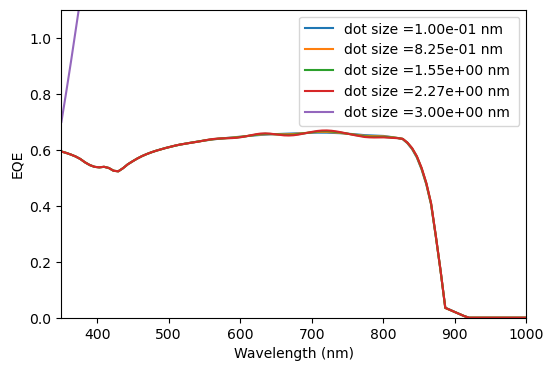

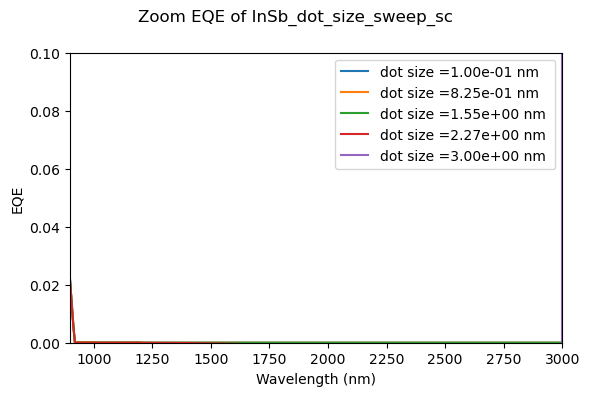

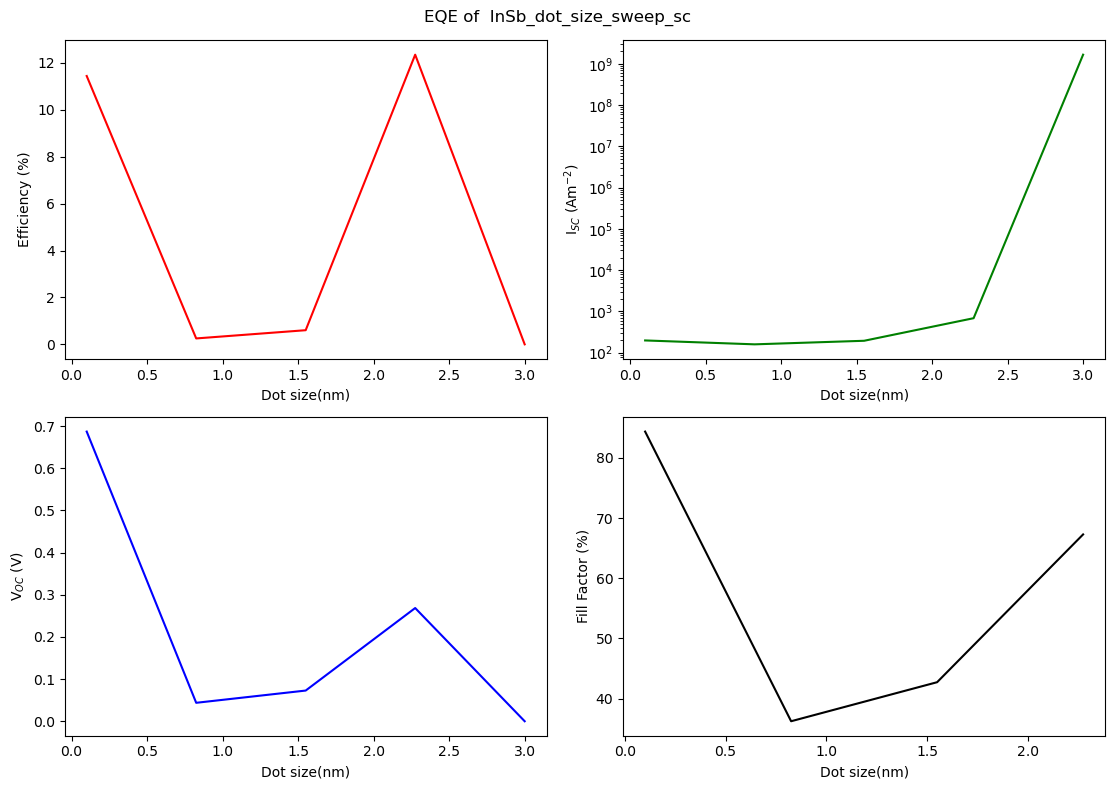

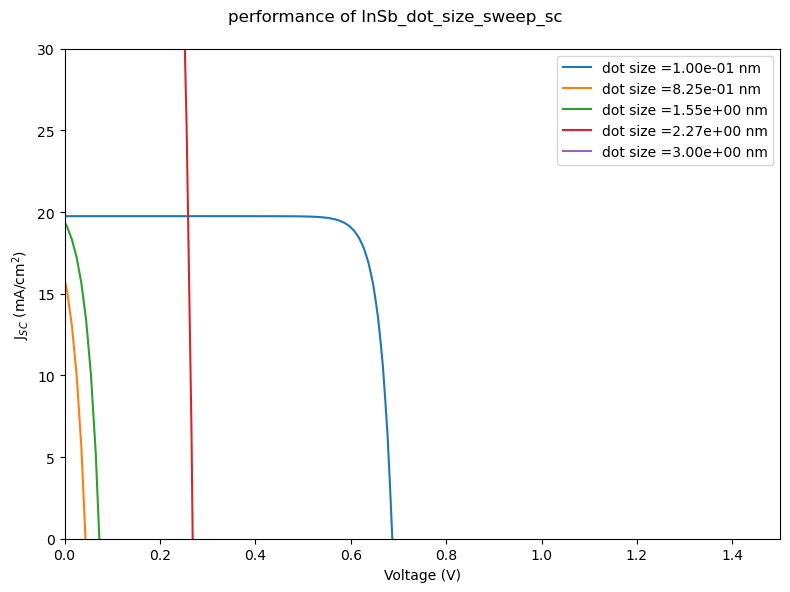

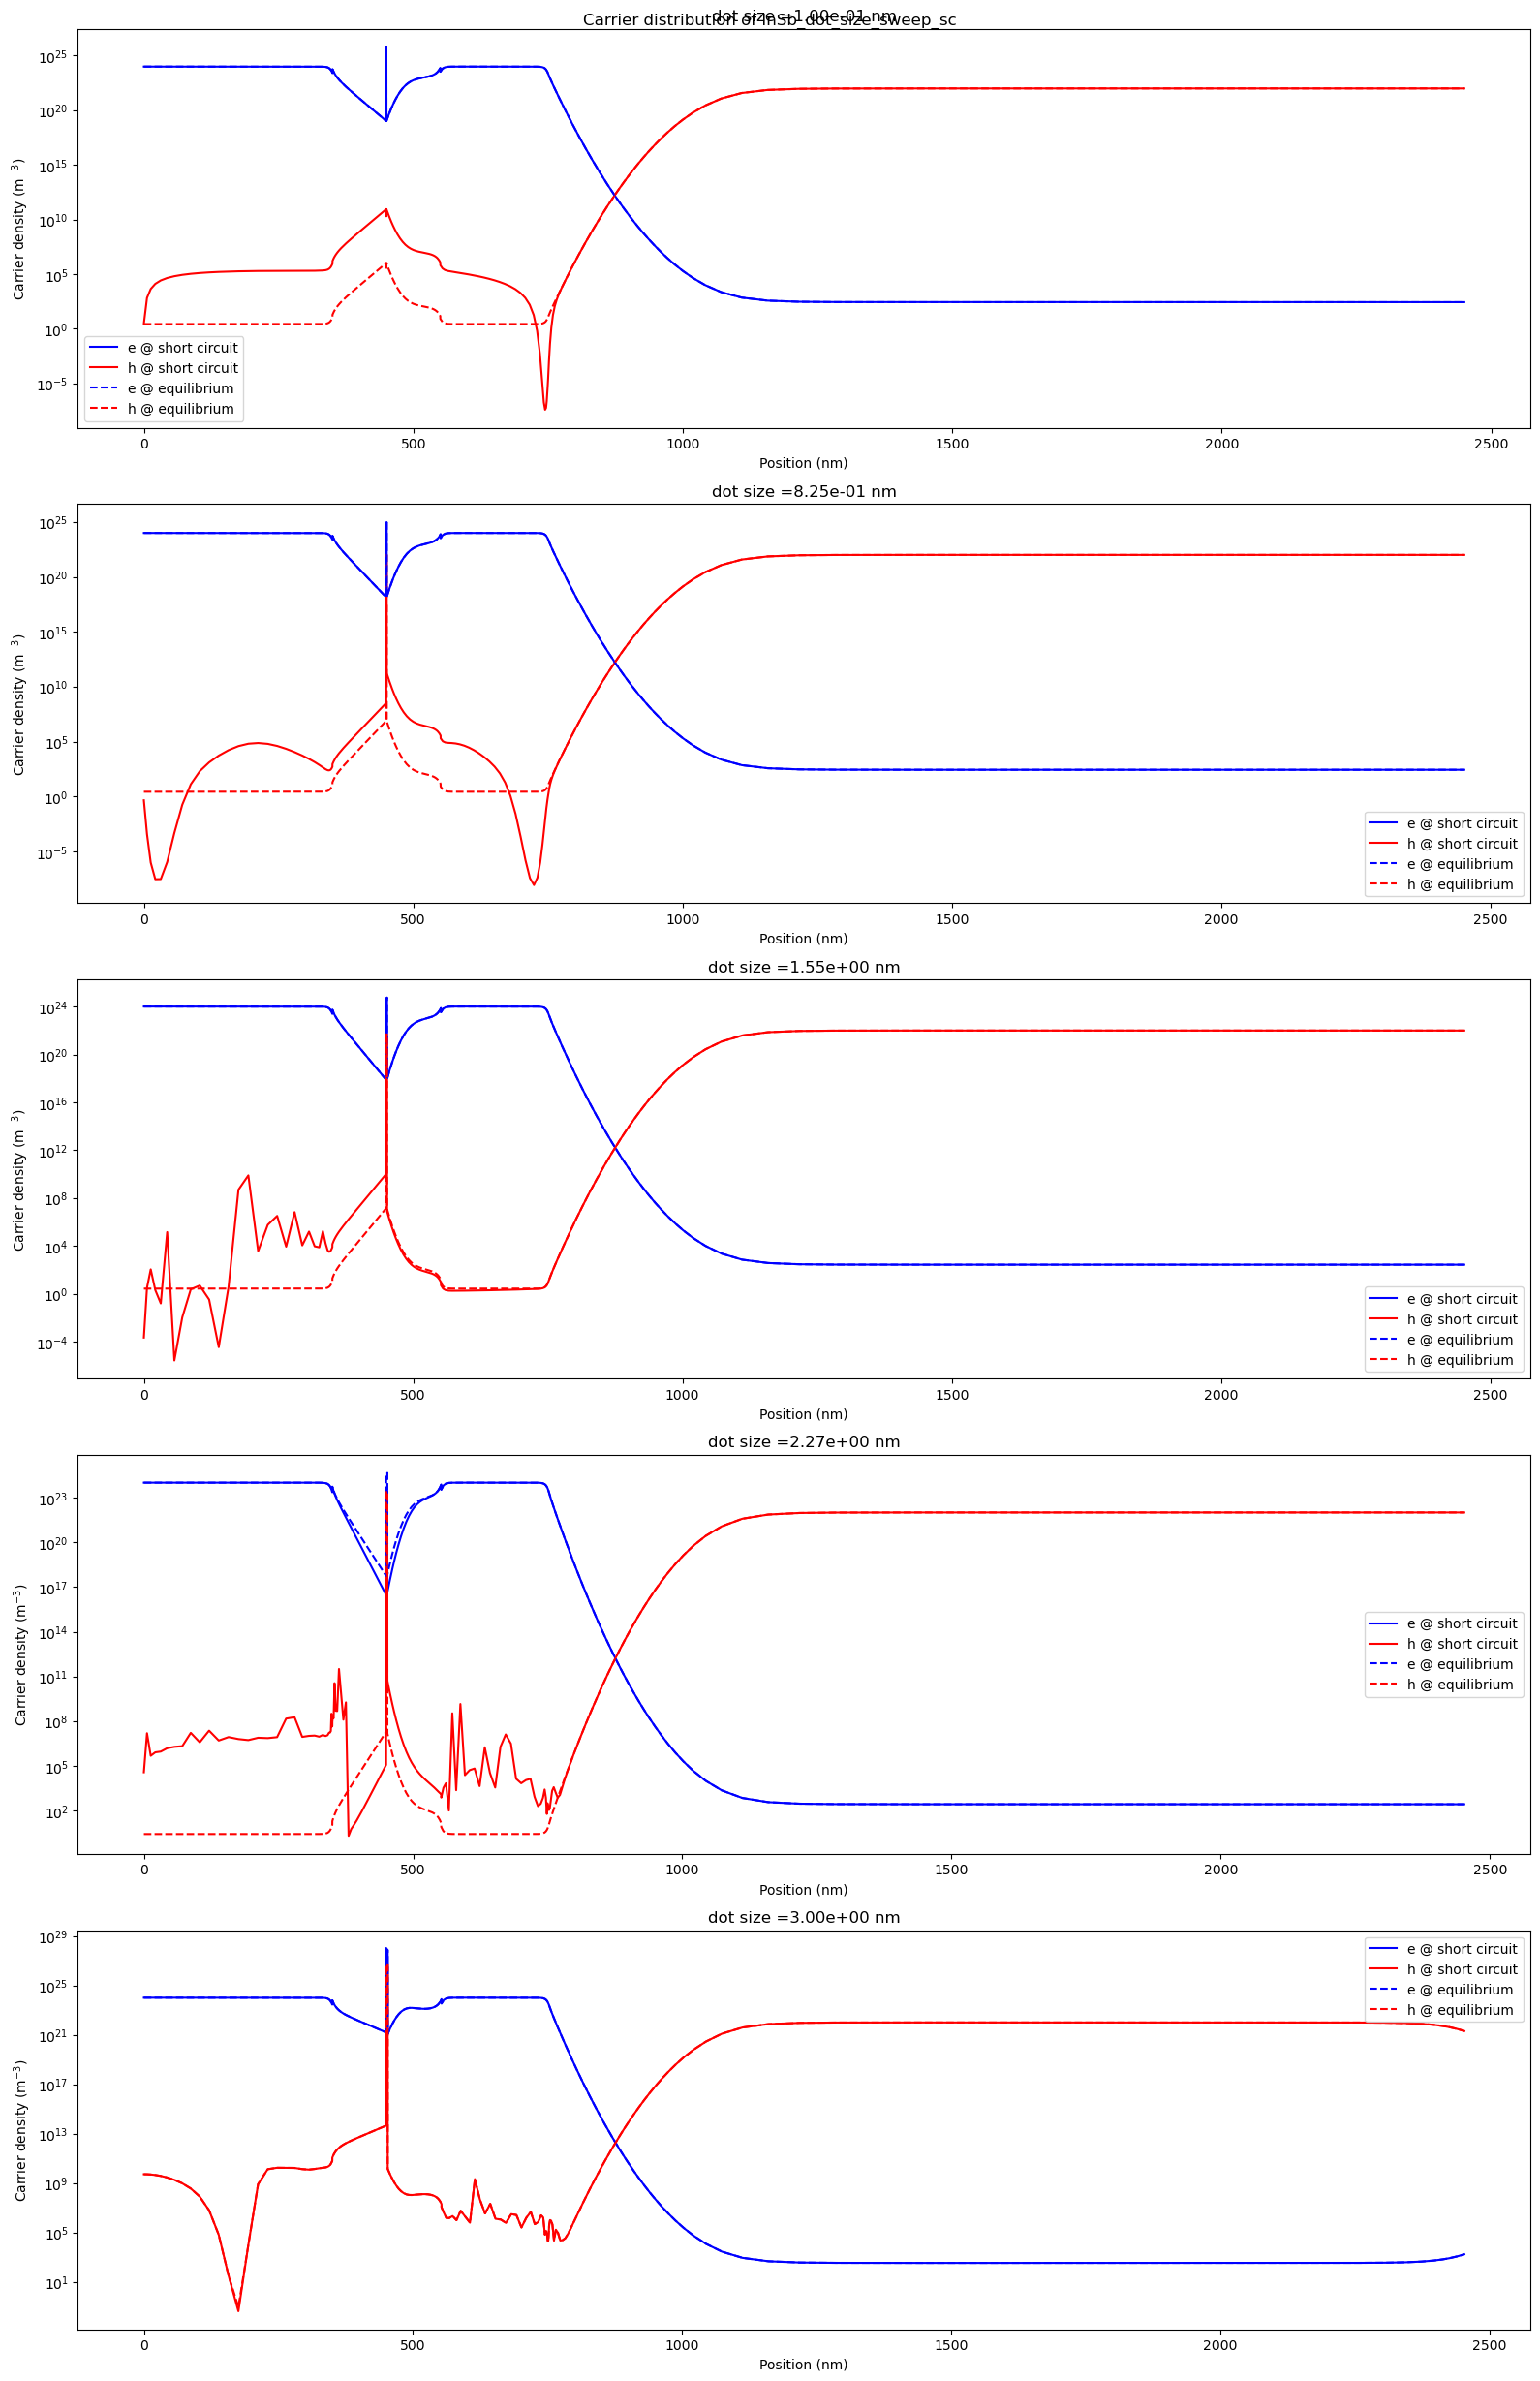

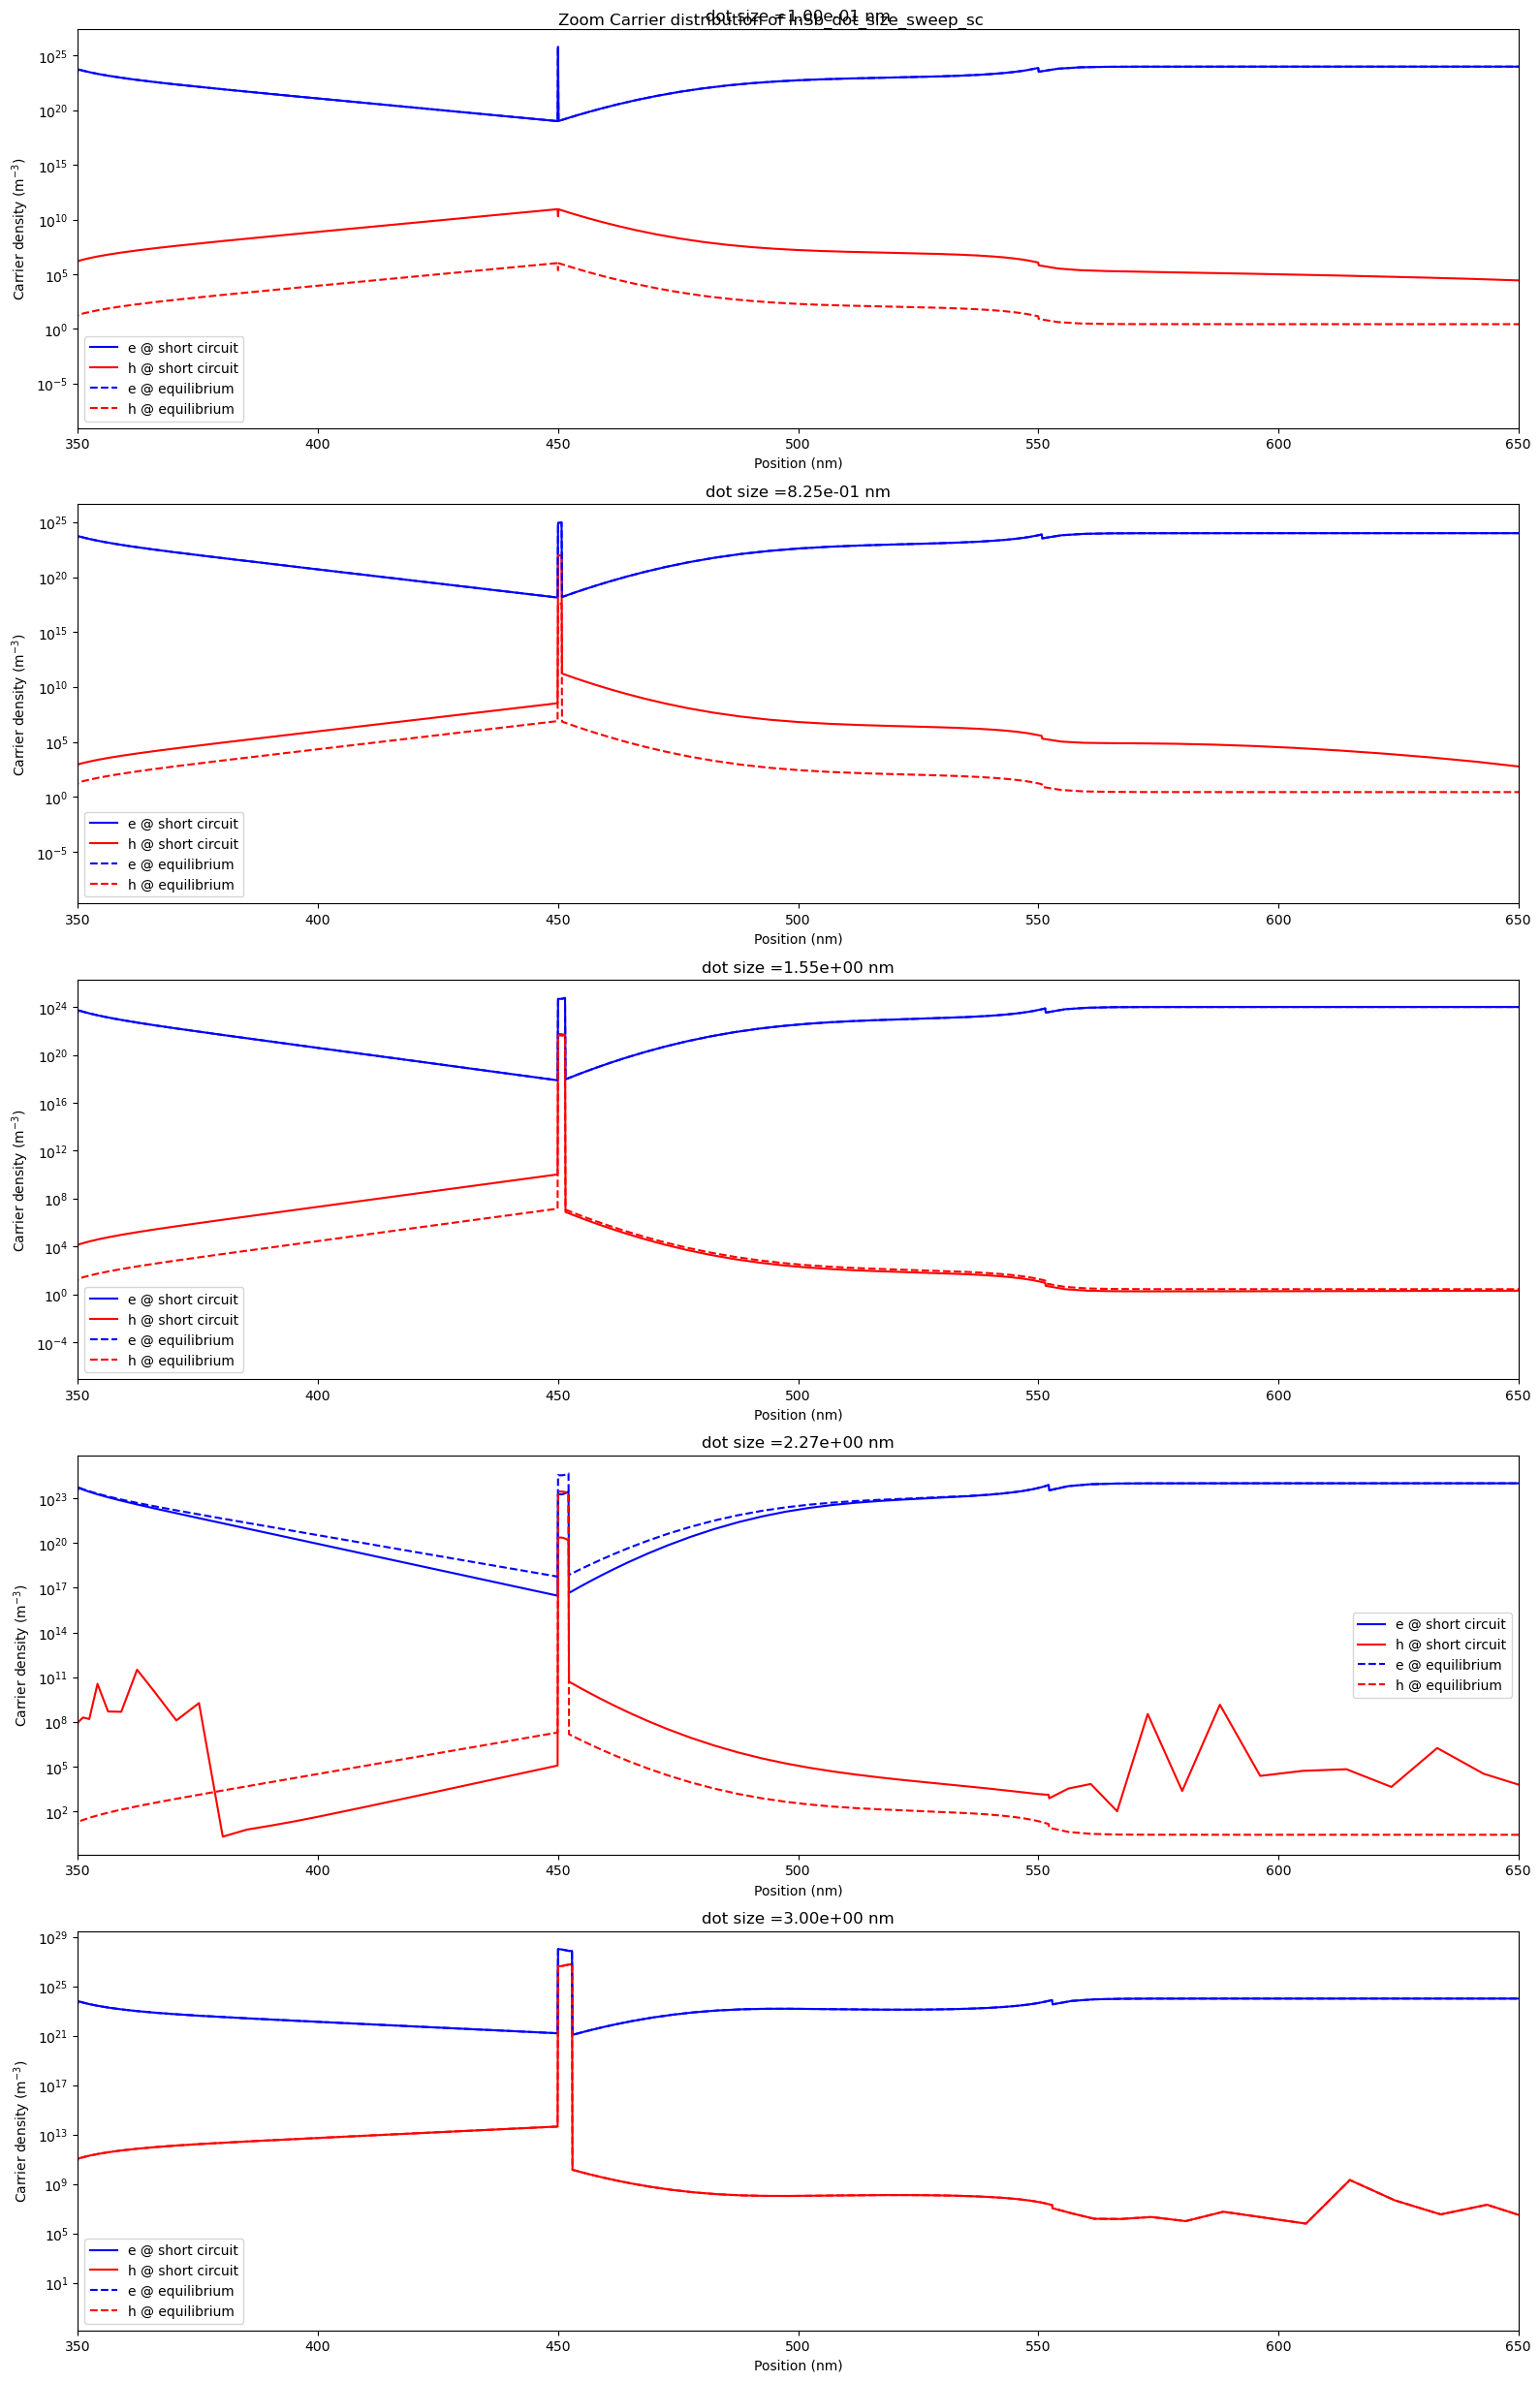

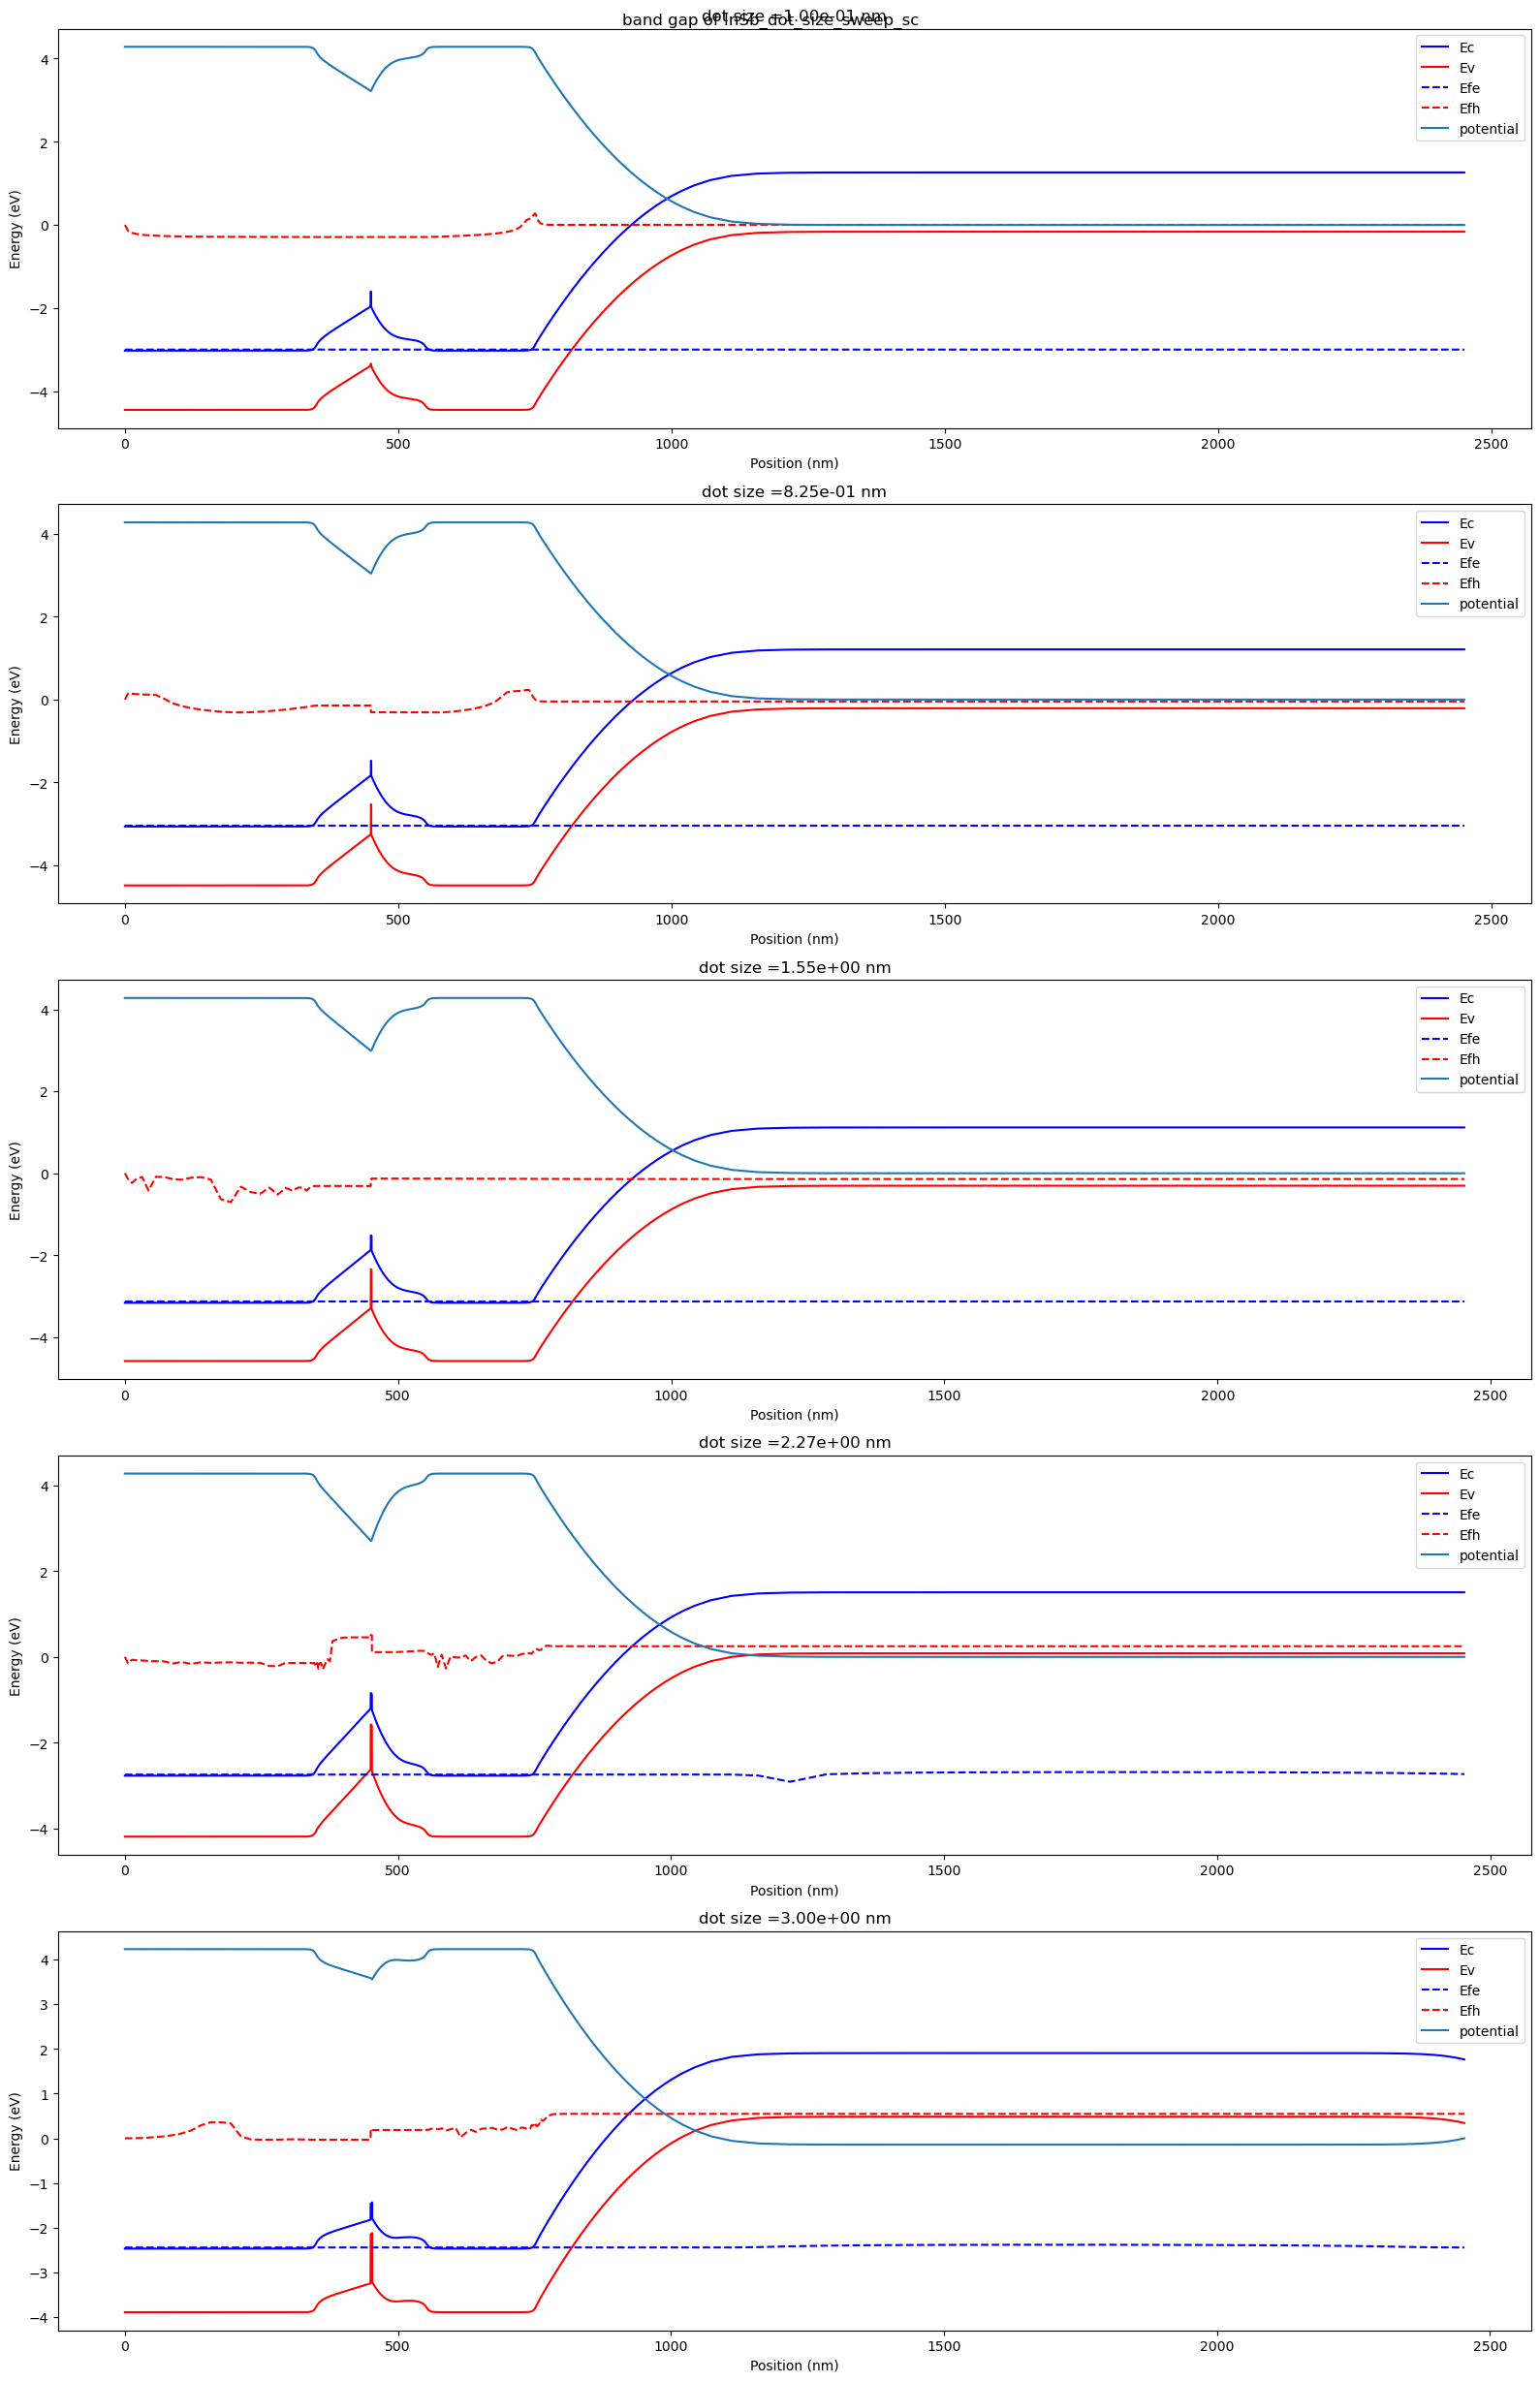

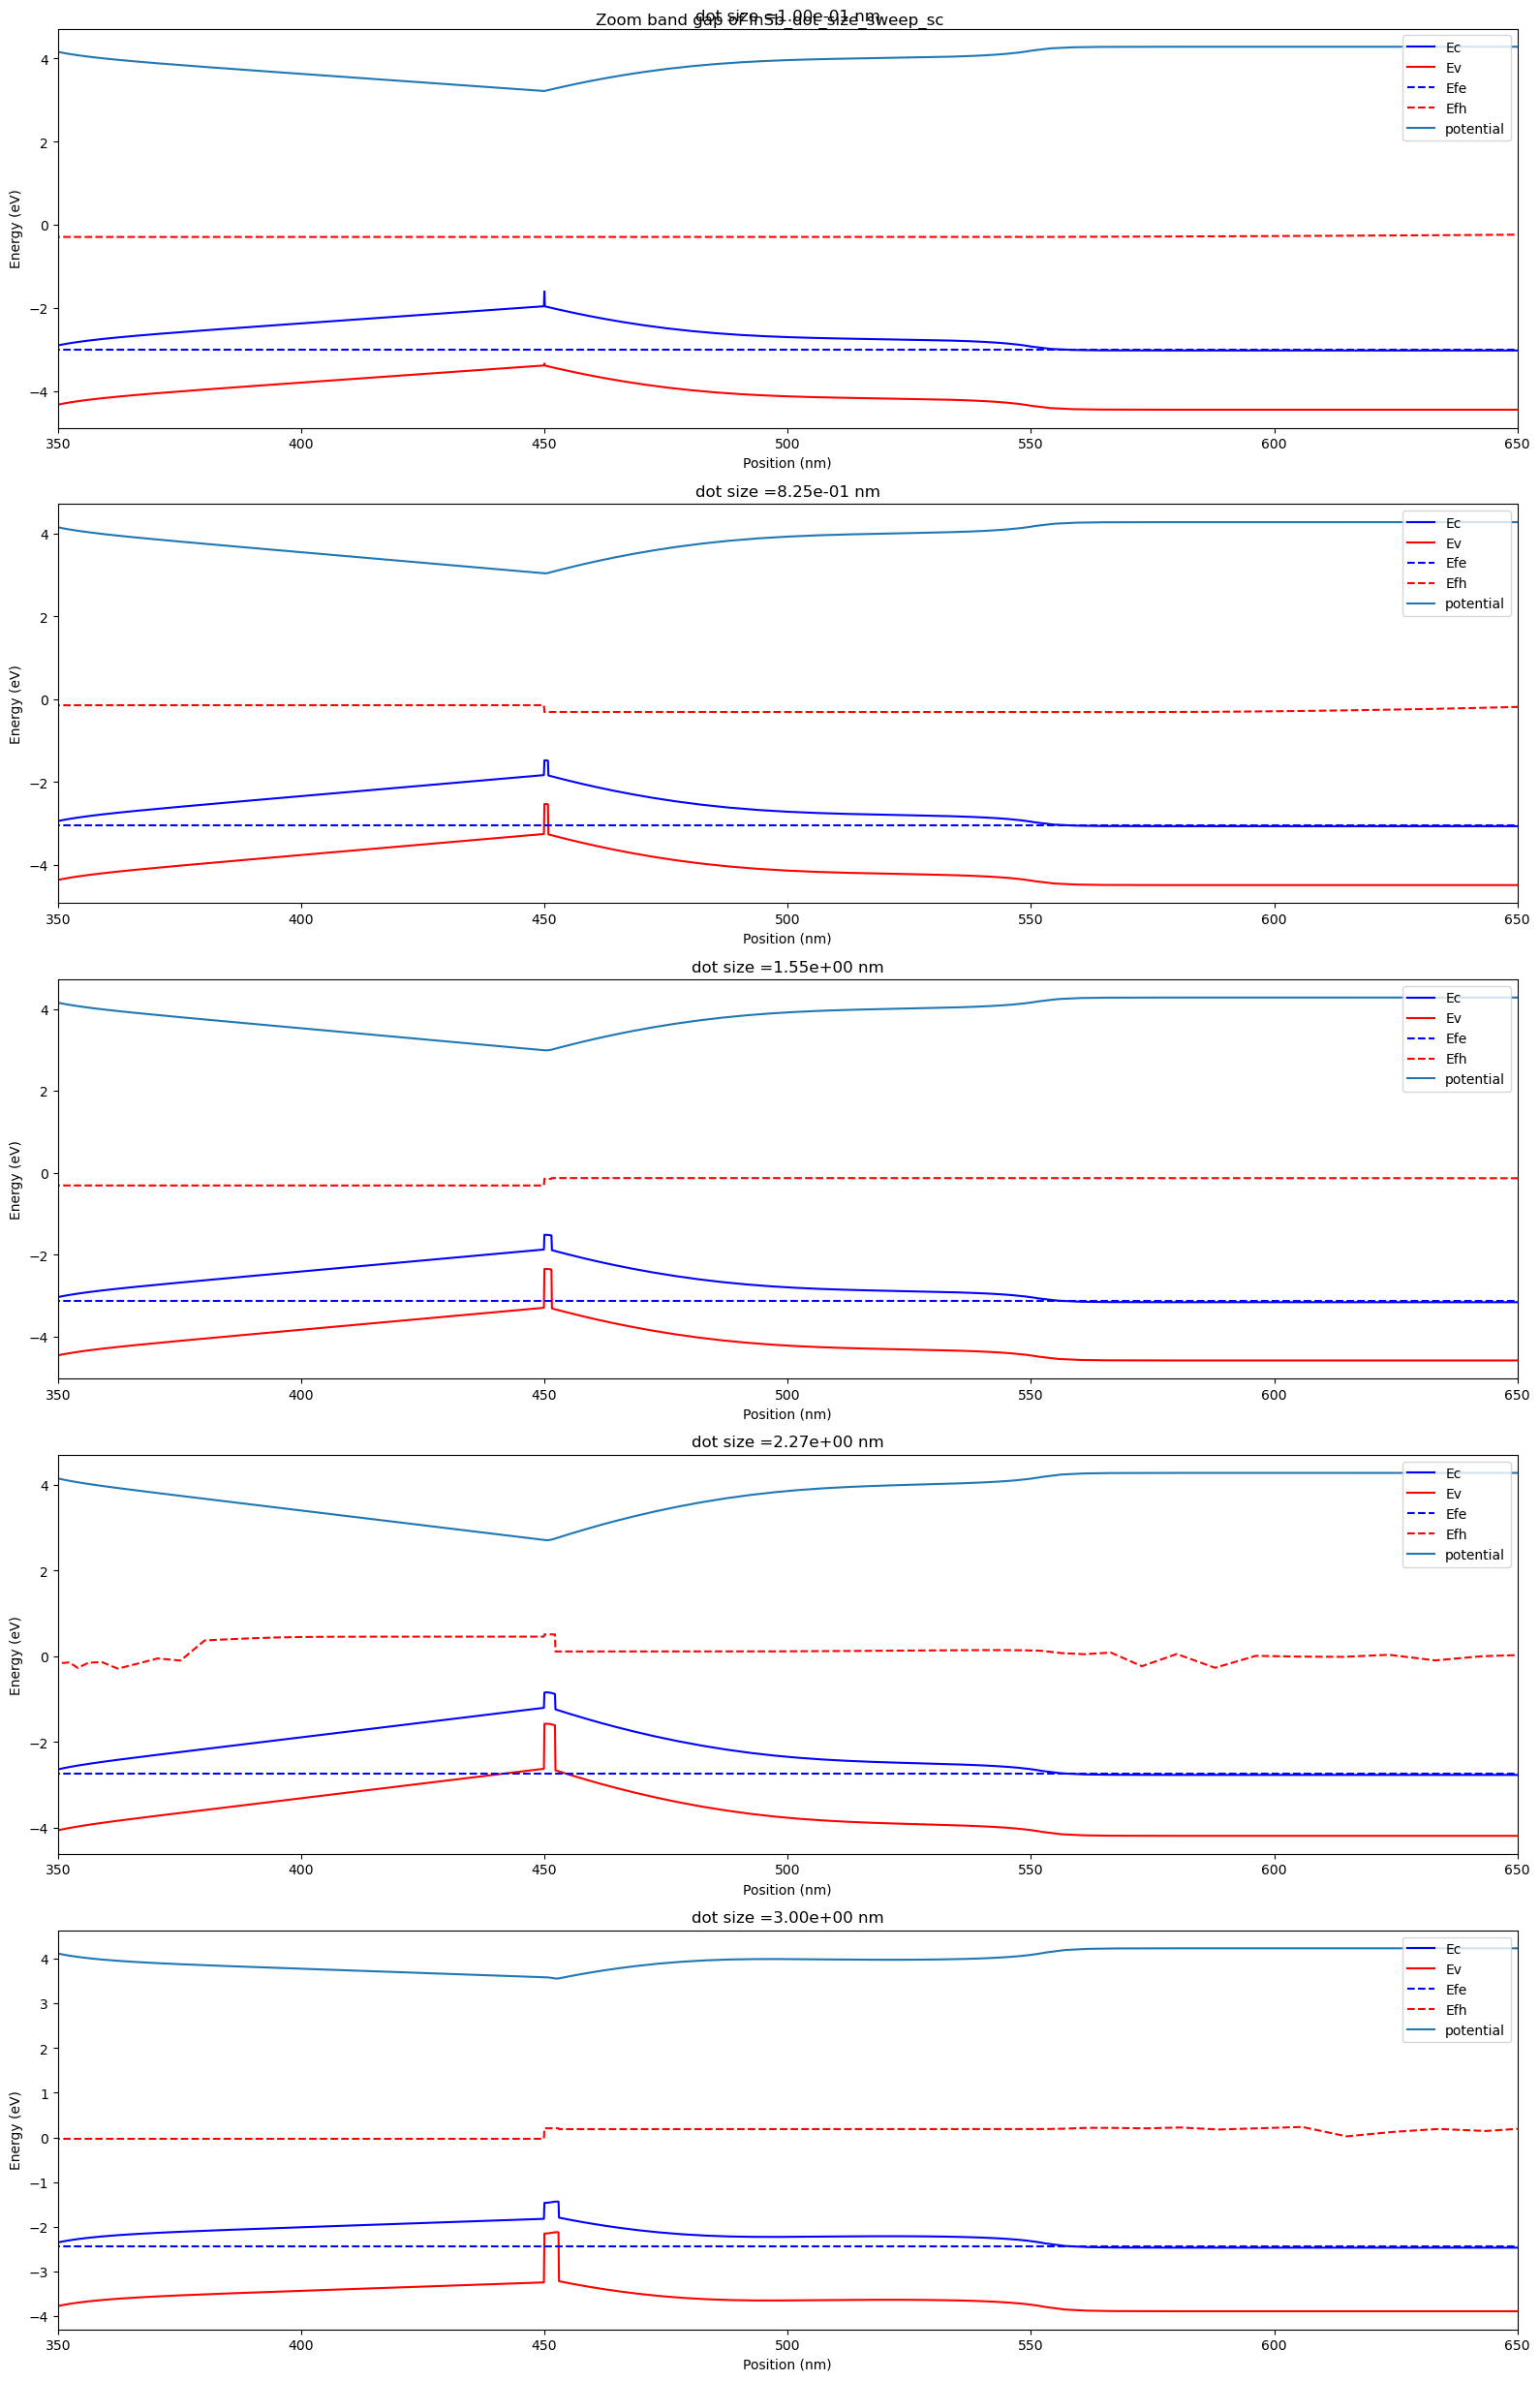

In [43]:
version = "InSb_dot_size_sweep_sc"
sim_mat, plot_note = InSb_dot_size_sweep()
note = 'default'
start = time.perf_counter()
set_of_data_sun_constant =simulation1D_sun_constant(version, sim_mat, plot_note, note=note, focus_level=maxfocuse)
stop = time.perf_counter()
hours, minutes, seconds = sec_to_hms(stop - start)
print(f"this run take time {hours} hours/ {minutes} minutes/ {seconds} seconds")
# root = tk.Tk()
# root.withdraw()
save_set_of_data_sun_constant(set_of_data_sun_constant, version)
# note_from_mat = dict(x_axis=list, x_axis_name="txt")
try:
    movefile(f'Carrier_distribution_{version}.html', f'{version}')
    movefile(f'Carrier_distribution_{version}_zoom.html', f'{version}')
    movefile(f'Band_diagramming_of_{version}.html', f'{version}')
    movefile(f'Band_diagramming_of_{version}_zoom.html', f'{version}')
except PermissionError as e:
    print(f"Error: {e}")

In [25]:
for i in sim_mat['dot size =1.00e-01 nm'][0].qe:
    print(i)
print(len(sim_mat['dot size =1.00e-01 nm'].absorbed))

EQE
EQEsrh
EQErad
EQEaug
EQEsurf
EQEsurb
WL
IQE
401


In [21]:

# for i in sim_mat.__dict__:
#     print(i)
# print(ToStructure(sim_mat))
# print(str(sim_mat))
for i in sim_mat.__dict__:
    print(i)
data_test = dict(
    T=sim_mat.T,
    absorbed=sim_mat.absorbed,
    short_circuit_data=sim_mat[0].short_circuit_data.copy(),
    pdd_data=sim_mat[0].pdd_data.copy(),
    recombination_currents=sim_mat[0].recombination_currents.copy(),
    equilibrium_data=sim_mat[0].equilibrium_data.copy(),    
    iv=sim_mat.iv.copy(),
    offset=sim_mat[0].offset
)
print('======================')
print(data_test["iv"]["Pmpp"])
for i in data_test["iv"]['Bandstructure']:
    print(i)

# with open(f'yoyo.pkl', 'wb') as fin:
#     pickle.dump(sim_mat[0], fin)    

labels
T
cell_area
shading
reflectivity
junctions
junction_indices
tunnel_indices
substrate
incidence
R_series
width
wavelength
reflected
transmitted
absorbed
iv
None


KeyError: 'Bandstructure'

In [7]:
flash = State
flash.meshpoints = -400
flash.growth_rate = 0.7
flash.coarse = 20e-9
flash.fine = 1e-9
flash.ultrafine = 0.2e-9
flash.RTol = 1e-4
flash.clamp = 20
for i in flash.__dict__:
    print(i)

__module__
__doc__
__getattr__
__setattr__
meshpoints
growth_rate
coarse
fine
ultrafine
RTol
clamp


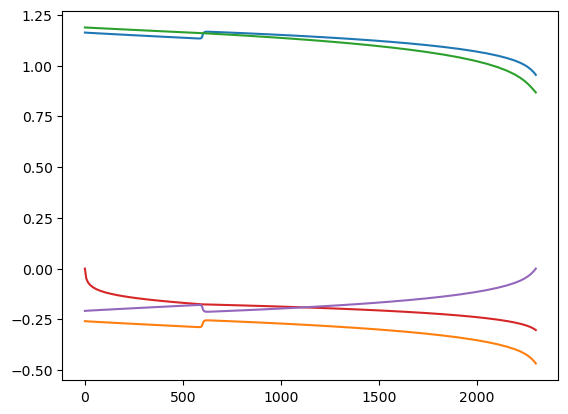

In [36]:
plt.plot(sim_mat[0].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['Ec'], label="Ec" )
plt.plot(sim_mat[0].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['Ev'], label="Ev")
plt.plot(sim_mat[0].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['Efe'],label="Efe")
plt.plot(sim_mat[0].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['Efh'],label="Efh")
plt.plot(sim_mat[0].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['potential'],label="potential")

In [39]:
sim_mat[0].pdd_data['positive_V']['Bandstructure']['Rho']

array([-7.44896948e-05, -3.44637757e-06,  8.97247971e-06,  8.75808460e-06,
        7.12683777e-06,  5.79704128e-06,  4.78637913e-06,  3.99114123e-06,
        3.35012965e-06,  2.82918972e-06,  2.40520941e-06,  2.06024687e-06,
        1.77981708e-06,  1.55189777e-06,  1.36598521e-06,  1.21282168e-06,
        1.08908609e-06,  1.29203802e-06,  2.07821727e-05,  1.03978292e-03,
        4.19787279e-02,  1.22418636e+00,  2.41766193e+01,  3.07540156e+02,
        2.44227049e+03,  1.19302671e+04,  3.59293763e+04,  7.02927466e+04,
        1.00989481e+05,  1.21666879e+05,  1.34302610e+05,  1.42296985e+05,
        1.47988564e+05, -1.32728916e+04, -7.21694846e+03, -3.91810391e+03,
       -2.37066303e+03, -1.80340423e+03, -1.64446718e+03, -1.60957790e+03,
       -1.60329869e+03, -1.60232851e+03, -1.60219518e+03, -1.60217851e+03,
       -1.60217659e+03, -1.60217638e+03, -1.60217636e+03, -1.60217636e+03,
       -1.60217635e+03, -1.60217635e+03, -1.60217635e+03, -1.60217635e+03,
       -1.60217634e+03, -

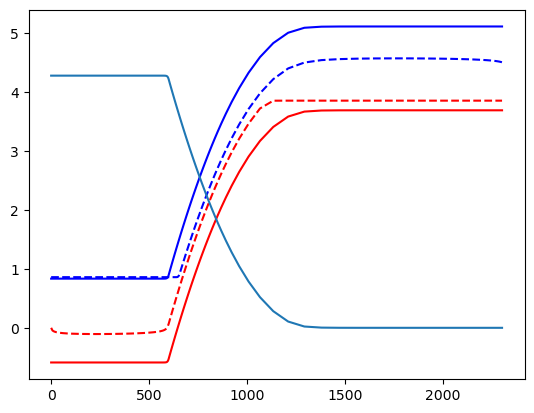

In [47]:
plt.plot(sim_mat[0].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['Ec'],'b', label="Ec" )
plt.plot(sim_mat[0].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['Ev'],'r',label="Ev")
plt.plot(sim_mat[0].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['Efe'],'b--', label="Efe")
plt.plot(sim_mat[0].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['Efh'],'r--',label="Efh")
plt.plot(sim_mat[0].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['potential'],label="potential")

array([-0.20857057, -0.20790873, -0.20738048, -0.20676396, -0.20598827,
       -0.20503475, -0.20390446, -0.20260919, -0.20116774, -0.19960353,
       -0.19794301, -0.19621445, -0.19444689, -0.19266847, -0.19090464,
       -0.18917812, -0.18751173, -0.1859325 , -0.18447267, -0.18316533,
       -0.1820365 , -0.1810985 , -0.18034806, -0.1797724 , -0.17937802,
       -0.17927071, -0.17971503, -0.18096089, -0.18295641, -0.18538046,
       -0.18793941, -0.19058341, -0.19359097, -0.19397952, -0.19910591,
       -0.20353832, -0.20716786, -0.20978221, -0.21139425, -0.21223242,
       -0.21257651, -0.21264443, -0.21257012, -0.212425  , -0.21224382,
       -0.21204239, -0.21182747, -0.21160178, -0.21136648, -0.21112231,
       -0.21086987, -0.21060966, -0.21034199, -0.21006699, -0.20978478,
       -0.20949552, -0.20919923, -0.20889527, -0.20858187, -0.20825609,
       -0.2079145 , -0.20755405, -0.20717262, -0.20676871, -0.20634058,
       -0.20588562, -0.20539969, -0.20487532, -0.204297  , -0.20